Things to include:
1.	A description of the variable and a time-series plot
2.	A detailed description of the methodology that you plan to employ.
3.	A description of the forecasting model you used (including parameter values of the
model)
4.	Forecasts of the series for the next year (e.g. 12 values for a monthly variable), inclusive
of the value on the release date 
5.	The computer code (e.g. a Stata .do file) used to generate the forecast


In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")
warnings.filterwarnings("ignore", message="An unsupported index was provided. As a result, forecasts cannot be generated.")
from statsmodels.tsa.ardl import ARDL

### Reading In The Data

I've made the decision to remove the Covid datapoints from the unemployment (Feb 2020 until March 2022). The data is replaced with generated data based on the mean and variance of the 12 months before Covid and 13 months after Covid concated together. My logic is that covid was an anomalous event that doesn't represent the trends' of the business cycle. It could have, however, effected the unemployment after the shock happened but that is hopefully covered by the two years worth of datapoints afterwards (2022-2024).

In [328]:
unrate = pd.read_csv('UNRATE (2).csv')
unrate['DATE'] = pd.to_datetime(unrate['DATE'])

# Making unrate_removed
start_date = '2020-02-01'
end_date = '2022-03-01'

pre_gap_data = unrate[unrate['DATE'] < start_date]
post_gap_data = unrate[unrate['DATE'] > end_date]

missing_period = pd.concat([pre_gap_data.tail(n=12)['UNRATE'], post_gap_data.head(n=13)['UNRATE']], ignore_index=True)
mean_post_gap = missing_period.mean()
variance_post_gap = missing_period.var()

missing_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
missing_values = np.random.normal(loc=mean_post_gap, scale=np.sqrt(variance_post_gap), size=len(missing_dates))

missing_data = pd.DataFrame({'DATE': missing_dates, 'UNRATE': missing_values})
unrate_removed = pd.concat([pre_gap_data, missing_data, post_gap_data], ignore_index=True)

unrate_removed = unrate_removed.sort_values(by='DATE').reset_index(drop=True)

### Checking for Stationarity

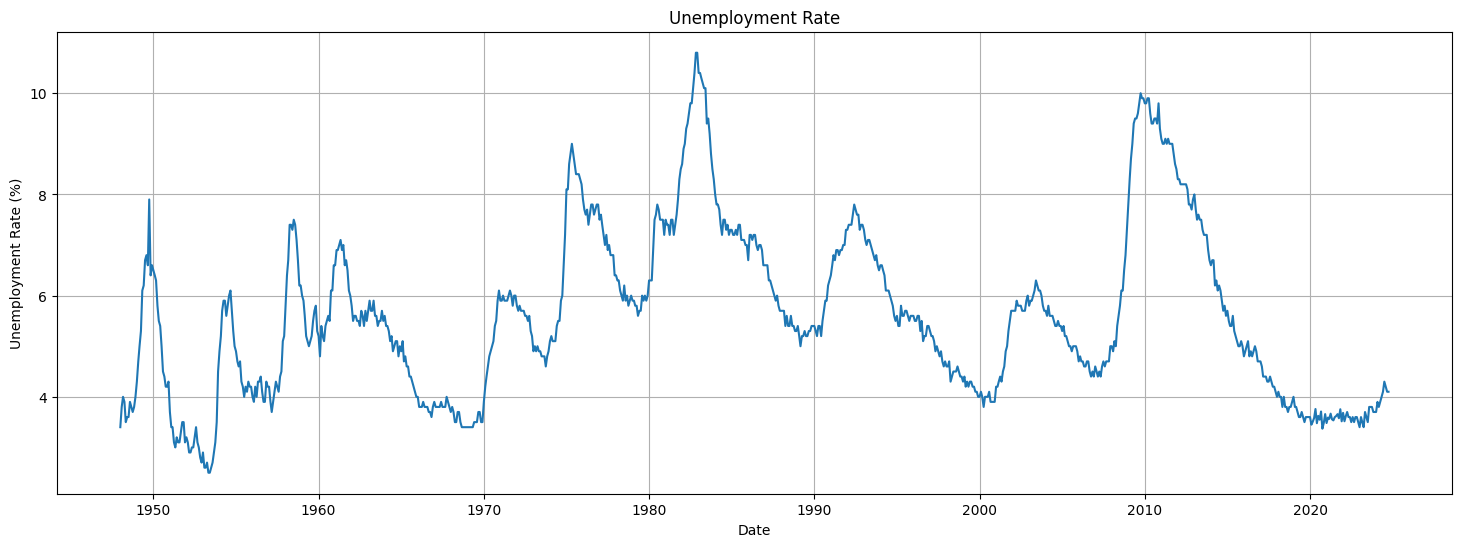

In [329]:
plt.figure(figsize=(18, 6))  # Adjust the width (12) and height (6)
plt.plot(unrate_removed['DATE'], unrate_removed['UNRATE'])
plt.title('Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.show()

To test for mean and variance stationarity we can run an ADF Test:

In [330]:
# Check the Augmented Dickey Fuller Test for mean stationarity
print("""I will check both the Covid Included and Excluded dataset 
just to make sure me removind the covid data didn't effect
the data's stationarity\n""")

result = adfuller(unrate['UNRATE'], autolag='AIC', regression='c')
print(f'P value for the Covid INCLUDED Dateset: {result[1]:.3f}')

result = adfuller(unrate_removed['UNRATE'], autolag='AIC', regression='c')
print(f'P value for the Covid EXCLUDED Dataset: {result[1]:.3f}\n')

print(f"""The Null Hypothesis: The time series has a unit root (the series is non-stationary).
We can reject the null hypothesis since both p-value's are below 0.05.
These results mean that the series is both mean and variance stationary.""")

I will check both the Covid Included and Excluded dataset 
just to make sure me removind the covid data didn't effect
the data's stationarity

P value for the Covid INCLUDED Dateset: 0.002
P value for the Covid EXCLUDED Dataset: 0.039

The Null Hypothesis: The time series has a unit root (the series is non-stationary).
We can reject the null hypothesis since both p-value's are below 0.05.
These results mean that the series is both mean and variance stationary.


### Model Type Selection:

Since we already showed stationarity, the ARIMA model isn't needed here. We will focus on picking between a pure AR model, a pure MA model and a ARMA model. This will be done by looking at the ACF and PACF and using the AIC.

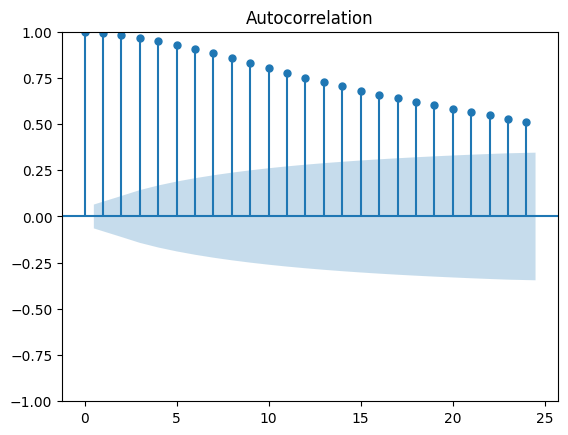

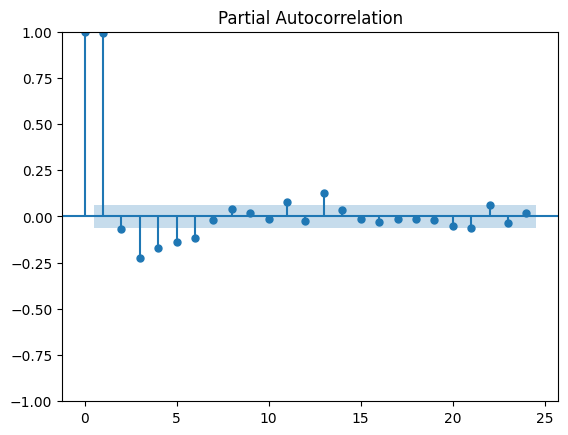

In [331]:
# Check Autocorrelation plots (ACF)
plot_acf(unrate_removed['UNRATE'], lags=24);
plot_pacf(unrate_removed['UNRATE'], lags=24);

Given the structure of the ACF, an AR(6) model seems appropriate. This is because for an AR Model, the PACF should show significant lags up to a certain point (in this case 6 lags) and then cut off into insignificance and the ACF should taper off gradually, which is what is observed in the graphs above.

For the MA and ARMA Models:

MA Model: Use when the ACF shows significant lags up to a certain point (and then cuts off) but the PACF tapers off gradually.

ARMA Model: Use when both ACF and PACF taper off without a clear cutoff.

Neither of these is what is seen in the graphs so I don't think they are the correct models, even so we can double check by testing them using the AIC:

### AR Model AIC

In [332]:
def do_aic(data=unrate['UNRATE'], l=2):
    model = AutoReg(data, lags=l)
    model_fitted = model.fit()
    aic = model_fitted.aic
    return aic

lst = []
for lag in range(1, 13):
    lst.append(do_aic(data=unrate_removed['UNRATE'], l=lag))

min_index = lst.index(np.min(lst)) + 1
print(f"The Model with the minimum AIC SSR is an AR({min_index}) model: {np.min(lst):.3f}")

The Model with the minimum AIC SSR is an AR(6) model: -446.780


### ARMA Model AIC
(Im using the ARIMA Function since for stationary data it should act the same)

In [333]:
# def do_aic_arma(data, p=2, q=2): 
#     model = ARIMA(data, order=(p, 0, q))  # AR(p), I(0), MA(q)
#     model_fitted = model.fit()
#     aic = model_fitted.aic
#     return aic

# aic_values = []
# for q in range(1, 8):  # MA order from 1 to 7
#     for p in range(1, 8):  # AR order from 1 to 7
#         aic = do_aic_arma(data=unrate_removed['UNRATE'], p=p, q=q)
#         aic_values.append((aic, p, q))

# min_aic, best_p, best_q = min(aic_values, key=lambda x: x[0])

# print(f"The Model with the minimum AIC SSR is an AR({best_p}) MA({best_q}) model: {min_aic:.3f}")

### MA Model AIC

In [334]:
# def do_aic_ma(data, q=2): 
#     model = ARIMA(data, order=(0, 0, q))  # AR(0), I(0), MA(q)
#     model_fitted = model.fit()
#     aic = model_fitted.aic
#     return aic

# aic_values = []
# for q in range(1,12):  # MA order from 1 to 7
#     aic = do_aic_ma(data=unrate_removed['UNRATE'], q=q)
#     aic_values.append((aic, 0, q))  # p is always 0 for MA models

# min_aic, best_p, best_q = min(aic_values, key=lambda x: x[0])

# print(f"The Model with the minimum AIC SSR is an AR({best_p}) MA({best_q}) model: {min_aic:.3f}")

So actually, it seems that an ARMA(7,7) is the better model to use here. Its strange considering the shape of the ACF and PACF so what I will do is calculate the BIC since this might be a case of overfitting (Notice how q,p are ranging from 1 to 7 in the code and its ARMA(7,7) that gives the best AIC). It leads me to believe it may be choosing as many parameters to try and perfectly fit the data.

### ARMA BIC

In [335]:
# def do_aic_arma(data, p=2, q=2):
#     model = ARIMA(data, order=(p, 0, q))  # AR(p), I(0), MA(q)
#     model_fitted = model.fit()
#     bic = model_fitted.bic
#     return bic

# bic_values = []
# for q in range(1, 8):  # MA order from 1 to 7
#     for p in range(1, 8):  # AR order from 1 to 7
#         bic = do_aic_arma(data=unrate_removed['UNRATE'], p=p, q=q)
#         bic_values.append((aic, p, q))

# min_aic, best_p, best_q = min(bic_values, key=lambda x: x[0])

# print(f"The Model with the minimum BIC SSR is an AR({best_p}) MA({best_q}) model: {min_aic:.3f}")

#### AR BIC

In [336]:
# def do_aic(data=unrate['UNRATE'], l=2):
#     model = AutoReg(data, lags=l)
#     model_fitted = model.fit()
#     bic = model_fitted.bic
#     return bic

# lst = []
# for lag in range(1, 13):
#     lst.append(do_aic(data=unrate_removed['UNRATE'], l=lag))

# min_index = lst.index(np.min(lst)) + 1
# print(f"The Model with the minimum BIC SSR is an AR({min_index}) model: {np.min(lst):.3f}")

It looks like it may have actually been a case of overfitting, here is the full data:

| Model | AIC      | BIC      |
|-------|----------|----------|
| AR    | -443.939 | -405.378 |
| ARMA  | -462.342 | -152.149 |


#### AR(6) AIC -435.042, ARMA(7,7) AIC -449.677, AR(6) BIC -396.482, ARMA BIC -151.400

With respect to AIC, ARMA(7,7) seems to barely edge out AR(6). However, with respect to the BIC AR(6) is absolutley the better option and given how much worse ARMA(7,7) got when we considered BIC, I think its plausible to call this a case of overfitting.

#### Moving Forward with an AR(6):

In [337]:
"""# Fitting Model
model = AutoReg(unrate_removed['UNRATE'], lags=6)
fitted = model.fit()

# Getting Model Residuals
residuals = fitted.resid
noise_std_dev = residuals.std()

# Getting Noise Term
#noise_std_dev = unrate1['UNRATE'].iloc[-24:].var()

# 1 Year Forecast Predictions
forecast = fitted.predict(start=len(unrate_removed), end=len(unrate_removed) + 11) # change 35 to 11

# Calculate the standard error of the forecast (for each point)
horizon = np.arange(1, len(forecast) + 1)
forecast_se = noise_std_dev * np.sqrt(horizon)


# Calculate 95% confidence intervals (Z-value for 95% CI = 1.96)
ci_upper = forecast + 1.96 * forecast_se
ci_lower = forecast - 1.96 * forecast_se

# Adding noise to forecast
# epsilon = np.random.normal(0, noise_std_dev, size=len(forecast))
# forecast = np.round(forecast + epsilon, 2)

# Creating dates for 1 year ahead forecasting
last_date = unrate_removed['DATE'].max()
extra_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS') #change periods back to 12 again
extra_data_removed = pd.DataFrame({'DATE': extra_dates, 'UNRATE': forecast, 'CI_lower': ci_lower, 'CI_upper': ci_upper})

# Plotting original data
plt.figure(figsize=(12, 6))
plt.plot(unrate_removed['DATE'][-147:], unrate_removed['UNRATE'][-147:], label='Original Data', color='blue')

# Plotting forecasted data
plt.plot(extra_data_removed['DATE'], extra_data_removed['UNRATE'], label='1 Year Forecast', color='blue', linestyle = '--')

# Plotting the 95% confidence interval as a shaded region (fan chart)
plt.fill_between(extra_data_removed['DATE'], extra_data_removed['CI_lower'], extra_data_removed['CI_upper'], color='red', alpha=0.3, label='95% Confidence Interval')


# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('UNRATE')
plt.title('UNRATE with 1-Year Forecast (Without COVID)')
plt.legend()
plt.show()"""

"# Fitting Model\nmodel = AutoReg(unrate_removed['UNRATE'], lags=6)\nfitted = model.fit()\n\n# Getting Model Residuals\nresiduals = fitted.resid\nnoise_std_dev = residuals.std()\n\n# Getting Noise Term\n#noise_std_dev = unrate1['UNRATE'].iloc[-24:].var()\n\n# 1 Year Forecast Predictions\nforecast = fitted.predict(start=len(unrate_removed), end=len(unrate_removed) + 11) # change 35 to 11\n\n# Calculate the standard error of the forecast (for each point)\nhorizon = np.arange(1, len(forecast) + 1)\nforecast_se = noise_std_dev * np.sqrt(horizon)\n\n\n# Calculate 95% confidence intervals (Z-value for 95% CI = 1.96)\nci_upper = forecast + 1.96 * forecast_se\nci_lower = forecast - 1.96 * forecast_se\n\n# Adding noise to forecast\n# epsilon = np.random.normal(0, noise_std_dev, size=len(forecast))\n# forecast = np.round(forecast + epsilon, 2)\n\n# Creating dates for 1 year ahead forecasting\nlast_date = unrate_removed['DATE'].max()\nextra_dates = pd.date_range(start=last_date + pd.DateOffset(mo

#### ADL Forecasting

In [338]:
UNCLMS = pd.read_csv('ICSA (1).csv')
UNCLMS['DATE'] = pd.to_datetime(UNCLMS['DATE'])

UNCLMS.set_index('DATE', inplace=True)

monthly_data = UNCLMS.resample('MS').first()

covid_start = "2020-03-01"
covid_end = "2022-02-28"

pre_covid_data = monthly_data[monthly_data.index < pd.to_datetime(covid_start)]
post_covid_data = monthly_data[monthly_data.index > pd.to_datetime(covid_end)]

missing_period = pd.concat([pre_covid_data.tail(12), post_covid_data.head(13)])
mean_post_covid = missing_period.mean()
variance_post_covid = missing_period.var()

missing_dates = pd.date_range(start=covid_start, end=covid_end, freq='MS')
missing_values = np.random.normal(loc=mean_post_covid['ICSA'], scale=np.sqrt(variance_post_covid['ICSA']), size=len(missing_dates))
missing_data = pd.DataFrame({'DATE': missing_dates, 'ICSA': missing_values})

final_data = pd.concat([pre_covid_data, missing_data.set_index('DATE'), post_covid_data])
final_data = final_data.sort_index()

In [339]:
merged_data = pd.merge(unrate_removed, final_data, on='DATE', how='inner')
exog = merged_data[['ICSA']]

model = ARDL(merged_data['UNRATE'], lags=6, exog=exog, order=6)
results = model.fit()

forecast_start = len(merged_data)
forecast_end = forecast_start + 11

forecast = results.predict(start=forecast_start, end=forecast_end, exog_oos=exog.iloc[-12:])

print(forecast)


694    4.105753
695    4.041378
696    3.923527
697    3.867567
698    3.846008
699    3.819989
700    3.826001
701    3.825979
702    3.815968
703    3.822297
704    3.818618
705    3.877390
dtype: float64


Best model combination: Lag=7, Order=4
Lowest BIC: -637.367, Lowest AIC: -700.820


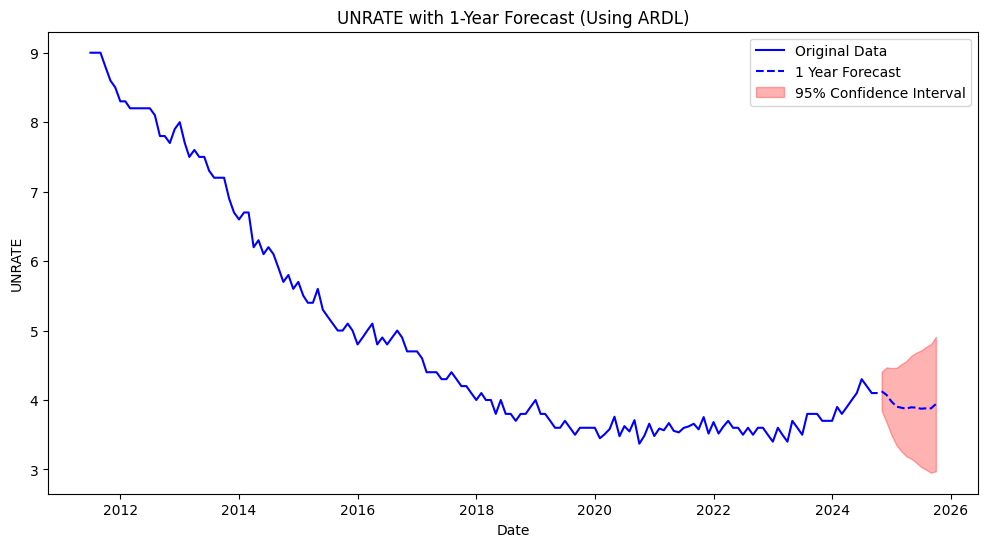

          DATE    UNRATE  CI_lower  CI_upper
694 2024-11-01  4.125685  3.846450  4.404920
695 2024-12-01  4.074182  3.679284  4.469079
696 2025-01-01  3.976416  3.492767  4.460064
697 2025-02-01  3.904840  3.346371  4.463310
698 2025-03-01  3.889468  3.265080  4.513856
699 2025-04-01  3.874645  3.190662  4.558628
700 2025-05-01  3.894763  3.155977  4.633549
701 2025-06-01  3.890447  3.100651  4.680242
702 2025-07-01  3.874526  3.036822  4.712230
703 2025-08-01  3.879950  2.996932  4.762968
704 2025-09-01  3.879065  2.952948  4.805182
705 2025-10-01  3.942086  2.974789  4.909384


In [342]:
def find_best_ardl_model(data, exog, max_lag=12, max_order=12):
    best_bic = float('inf')
    best_aic = float('inf')
    best_lag = None
    best_order = None

    for lag in range(1, max_lag + 1):
        for order in range(1, max_order + 1):
            model = ARDL(data, lags=lag, exog=exog, order=order)
            model_fitted = model.fit()

            aic = model_fitted.aic
            bic = model_fitted.bic
            
            if bic < best_bic or (bic == best_bic and aic < best_aic):
                best_bic = bic
                best_aic = aic
                best_lag = lag
                best_order = order
                continue
    print(f"Best model combination: Lag={best_lag}, Order={best_order}")
    print(f"Lowest BIC: {best_bic:.3f}, Lowest AIC: {best_aic:.3f}")
    
    return best_lag, best_order, best_bic, best_aic

best_lag, best_order, best_bic, best_aic = find_best_ardl_model(merged_data['UNRATE'], exog)

exog = merged_data[['ICSA']]
model = ARDL(merged_data['UNRATE'], lags=best_lag, exog=exog, order=best_order)
results = model.fit()

forecast_start = len(merged_data)
forecast_end = forecast_start + 11
forecast = results.predict(start=forecast_start, end=forecast_end, exog_oos=exog.iloc[-12:])

residuals = results.resid
noise_std_dev = residuals.std()

horizon = np.arange(1, len(forecast) + 1)
forecast_se = noise_std_dev * np.sqrt(horizon)

ci_upper = forecast + 1.96 * forecast_se
ci_lower = forecast - 1.96 * forecast_se

last_date = merged_data['DATE'].max()
extra_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS') 

extra_data = pd.DataFrame({'DATE': extra_dates, 'UNRATE': forecast, 'CI_lower': ci_lower, 'CI_upper': ci_upper})

plt.figure(figsize=(12, 6))
plt.plot(merged_data['DATE'][-160:], merged_data['UNRATE'][-160:], label='Original Data', color='blue')
plt.plot(extra_data['DATE'], extra_data['UNRATE'], label='1 Year Forecast', color='blue', linestyle='--')
plt.fill_between(extra_data['DATE'], extra_data['CI_lower'], extra_data['CI_upper'], color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('UNRATE')
plt.title('UNRATE with 1-Year Forecast (Using ARDL)')
plt.legend()
plt.show()
print(extra_data)